### Comparing multiple runs at selected locations

Hovmoller plots of temp, salt, N2, and BLD at selected locations.

Gustavo Marques (gmarques@ucar.edu)

In [1]:
from datetime import date
print("Last update:", date.today())

Last update: 2022-12-26


## Brief summary of the experiments 

* 1) CTRL-Z* 
* 2) LBD-Z* = CTRL-Z* + LBD + NNDIFF interior
* 3) CTRL-H 
* 4) LBD-H = CTRL-H + LBD + NNDIFF interior

They were all run for one cycle of the JRA-55 v1.3 

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import warnings, os
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.stats import mean_da
from mom6_tools.m6toolbox import request_workers, genBasinMasks, add_global_attrs 
from mom6_tools.m6plot import ztplot, xyplot
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

Basemap module not found. Some regional plots may not function properly


/glade/work/gmarques/miniconda/envs/dev2/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
path = '/glade/scratch/gmarques/'
path2 = '/glade/u/home/gmarques/Notebooks/CESM_MOM6/G/'
exps = ['gmom.e23.GJRAv4.TL319_t061_zstar_N65.nuopc.baseline.002', \
        'gmom.e23.GJRAv4.TL319_t061_zstar_N65.nuopc.HBD.002',  \
        'gmom.e23.GJRAv4.TL319_t061_hycom1_N75.nuopc.baseline.002',\
        'gmom.e23.GJRAv4.TL319_t061_hycom1_N75.nuopc.HBD.002']
labels = ['CTRL-z*', 'HBD-z*',  'CTRL-H', 'HBD-H']

# set this to true to save the plots
saveplot = True
if saveplot:
    os.system('mkdir PNG')

mkdir: cannot create directory ‘PNG’: File exists


In [4]:
# load grid and pre-difined masks
grd = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)
# get ocean area, xarray format
grd_xr = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc',xrformat=True)
area = grd_xr.area_t.where(grd.wet > 0)

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]
MOM6 grid successfully loaded... 



In [5]:
basin_code['yh'] = grd_xr.yh
basin_code['xh'] = grd_xr.xh

In [6]:
# load WOA18 data
obs_path = '/glade/u/home/gmarques/Notebooks/CESM_MOM6/WOA18_remapping/'
thetao_obs = xr.open_dataset(obs_path+'WOA18_TEMP_tx0.66v1_34lev_ann_avg.nc', decode_times=False)
salt_obs = xr.open_dataset(obs_path+'WOA18_SALT_tx0.66v1_34lev_ann_avg.nc', decode_times=False)

In [7]:
thetao_obs['xh'] = grd_xr.xh
salt_obs['xh'] = grd_xr.xh
thetao_obs['yh'] = grd_xr.yh
salt_obs['yh'] = grd_xr.yh

### Lab Sea 
Regional-averaged ocean properties

Max. depth in LabSea is: 4109.0


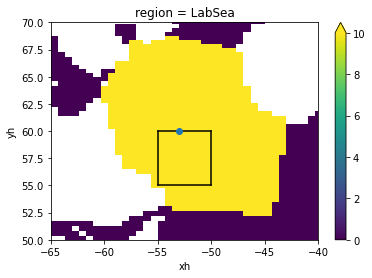

In [8]:
fig, ax = plt.subplots()
(basin_code.sel(region='LabSea')*grd_xr.depth_ocean).plot(ax=ax,vmax=10)
#(basin_code.sel(region='LabSea').sel(xh=slice(-55, -50)).sel(yh=slice(55, 60))*grd_xr.depth_ocean).plot(ax=ax)
ax.plot([-55,-50],[55.,55],'k')
ax.plot([-55,-50],[60.,60],'k')
ax.plot([-55,-55],[55.,60],'k')
ax.plot([-50,-50],[55.,60],'k')
ax.plot(-53.0,60.,'o')
ax.set_xlim(-65,-40)
ax.set_ylim(50,70)

print('Max. depth in LabSea is:',(basin_code.sel(region='LabSea')*grd_xr.depth_ocean).max().values)

In [9]:
def hovplot(ax,time, z, data, vmin=0, vmax=9, ylim=(-1000,0)):
  pc=ax.pcolormesh(time, z, data, vmin=vmin, vmax=vmax)
  ax.set_ylim(ylim)
  plt.colorbar(pc,ax=ax)
  tm, km = time.shape
  for k in range(km):
    ax.plot(time[:,k], z[:,k],'k', lw=0.1)

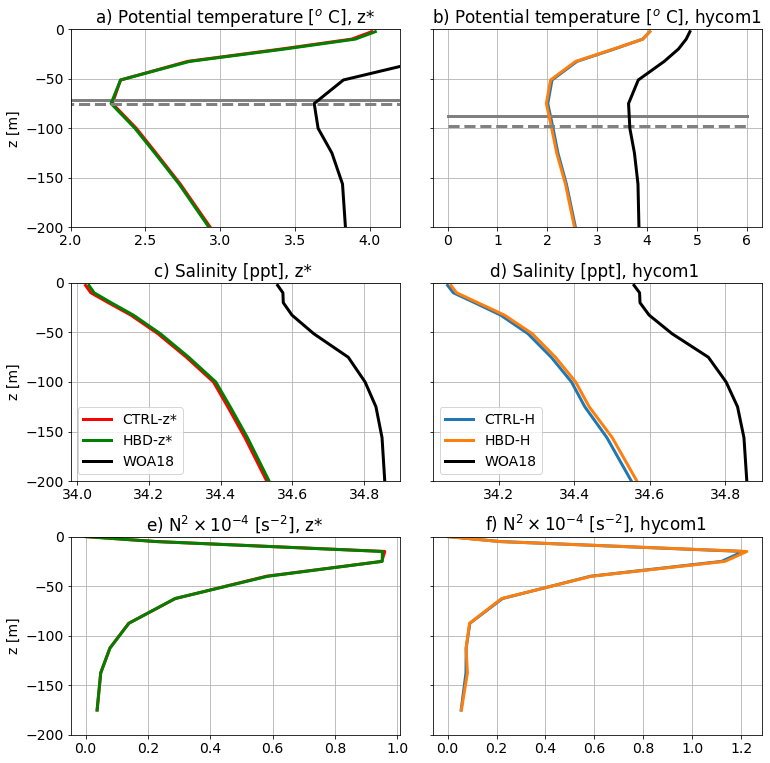

In [16]:
# profiles
#import seaborn as sns
#sns.set_theme(style="whitegrid")
matplotlib.rcParams.update({'font.size': 14})

# temperature
var = 'thetao'
sd='0001-01-01'
ed='0058-12-31'
reg='LabSea'
max_depth = 200.
lw=3
thetao_obs_lab = thetao_obs.sel(xh=-53., method="nearest").sel(yh=60., method="nearest").sel(z_l=slice(0,max_depth))
salt_obs_lab = salt_obs.sel(xh=-53., method="nearest").sel(yh=60., method="nearest").sel(z_l=slice(0,max_depth))


matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14), sharey=True)
#plt.suptitle('Potential Temperature [C], LabSea', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_tracer_z_point_'+reg+'.nc')
  ds = ds.sel(time=slice(sd,ed)).mean('time').sel(z_l=slice(0,max_depth))
  ds1 = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_oml_point_'+reg+'.nc')
  ds2 = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_N2_point_'+reg+'.nc')
  ds2 = ds2.sel(time=slice(sd,ed)).mean('time').sel(z_i=slice(0,max_depth))

  oml = ds1.oml.mean('time').values
  thetao = np.ma.masked_invalid(ds['thetao'].values)
  so = np.ma.masked_invalid(ds['so'].values)
  N2 = np.ma.masked_invalid(ds2['N2'].values)

  if i < 2:
    # z*
    if i == 0:
      ax1[0].plot(thetao,-ds.z_l.values, 'r', label=labels[i], lw=lw)
      ax1[2].plot(so,-ds.z_l.values, 'r', label=labels[i], lw=lw)
      ax1[4].plot(N2*1e4,-ds2.z_i.values, 'r', label=labels[i], lw=lw)
      ax1[0].plot([0,6],-np.ones(2)*oml,'-',color='gray', lw=lw)
    else:
      ax1[0].plot(thetao,-ds.z_l.values, 'g',label=labels[i], lw=lw)
      ax1[2].plot(so,-ds.z_l.values, 'g', label=labels[i], lw=lw)
      ax1[4].plot(N2*1e4,-ds2.z_i.values, 'g', label=labels[i], lw=lw)
      ax1[0].plot([0,6],-np.ones(2)*oml,'--',color='gray', lw=lw)
    

  else:
    ax1[1].plot(thetao,-ds.z_l.values, label=labels[i], lw=lw)
    if i == 2:
      ax1[1].plot([0,6],-np.ones(2)*oml,'-',color='gray', lw=lw)
    else:
      ax1[1].plot([0,6],-np.ones(2)*oml,'--', color='gray', lw=lw)
    
    ax1[3].plot(so,-ds.z_l.values, label=labels[i], lw=lw)
    ax1[5].plot(N2*1e4,-ds2.z_i.values, label=labels[i], lw=lw)
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1, hspace=0.28)

# obs
ax1[0].plot(thetao_obs_lab.theta0.values, -thetao_obs_lab.z_l.values,'k',label='WOA18', lw=lw)
ax1[1].plot(thetao_obs_lab.theta0.values, -thetao_obs_lab.z_l.values,'k',label='WOA18', lw=lw)
ax1[2].plot(salt_obs_lab.s_an.values, -salt_obs_lab.z_l.values,'k',label='WOA18', lw=lw)
ax1[3].plot(salt_obs_lab.s_an.values, -salt_obs_lab.z_l.values,'k',label='WOA18', lw=lw)

# grid
ax1[0].grid();ax1[1].grid()
ax1[2].grid();ax1[3].grid()
ax1[4].grid();ax1[5].grid()

# titles
ax1[0].set_title(r'a) Potential temperature [$^o$ C], z* ')
ax1[1].set_title(r'b) Potential temperature [$^o$ C], hycom1 ')
ax1[2].set_title(r'c) Salinity [ppt], z* ')
ax1[3].set_title(r'd) Salinity [ppt], hycom1 ')
ax1[4].set_title(r'e) N$^2 \times 10^{-4}$ [s$^{-2}$], z* ')
ax1[5].set_title(r'f) N$^2 \times 10^{-4}$ [s$^{-2}$], hycom1 ')

# ylabels
ax1[0].set_ylabel(r'z [m]')
ax1[2].set_ylabel(r'z [m]')
ax1[4].set_ylabel(r'z [m]')

# labels
ax1[2].legend()
ax1[3].legend()

# lims
ax1[0].set_xlim(2,4.2)
#ax1[1].set_xlim(3,5.2)
#ax1[2].set_xlim(34.45,34.9)
#ax1[3].set_xlim(34.45,34.9)
#ax1[4].set_xlim(-0.1,0.8)
#ax1[5].set_xlim(-0.1,0.8)

ax1[0].set_ylim(-200,0)
#ax1[0].invert_yaxis()
if saveplot:
    fname = 'PNG/profiles_lab_sea.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

In [17]:
ds2

<xarray.Dataset>
Dimensions:  (z_i: 10)
Coordinates:
  * z_i      (z_i) float64 0.0 5.0 15.0 25.0 40.0 62.5 87.5 112.5 137.5 175.0
Data variables:
    N2       (z_i) float32 0.0 2.131e-05 0.0001223 ... 8.102e-06 5.631e-06

AttributeError: 'Dataset' object has no attribute 'oml'

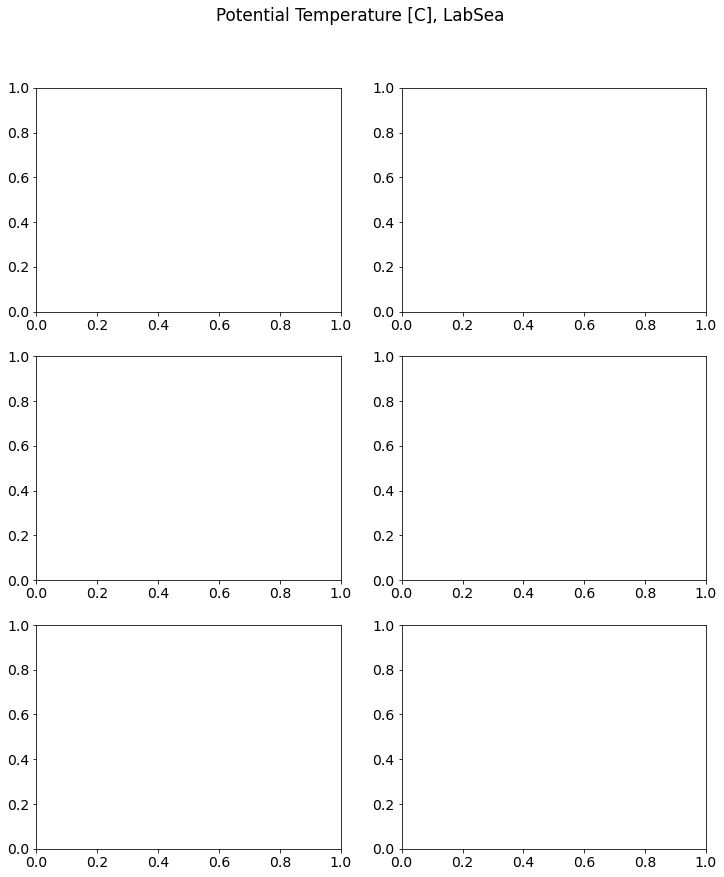

In [22]:
# temperature
var = 'thetao'
sd='0031-01-01'
ed='0038-12-31'
ct=False
clim=(-1, 9); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('Potential Temperature [C], LabSea', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset(path2+exps[i]+'/ncfiles/'+exps[i]+'_tracer_z_point_LabSea.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(z_l=slice(0,800))
  oml = ds.oml.values
  tm, km = ds[var].shape
  dummy = np.ma.masked_invalid(ds[var].values)
  e = np.zeros((tm,km+1))
  e[:,1::] = ds['h'].cumsum(axis=1).values
  dummy2, time = np.meshgrid(e[0,:],ds.time)
  hovplot(ax1[i],time,-e,dummy)
 
    
#fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

#cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
#cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
#cbar1.set_label(r'Potential temperature [$^oC$]', fontsize=14)

#cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
#cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
#cbar2.set_label(r'Difference in potential temperature [$^oC$]', fontsize=14)
 

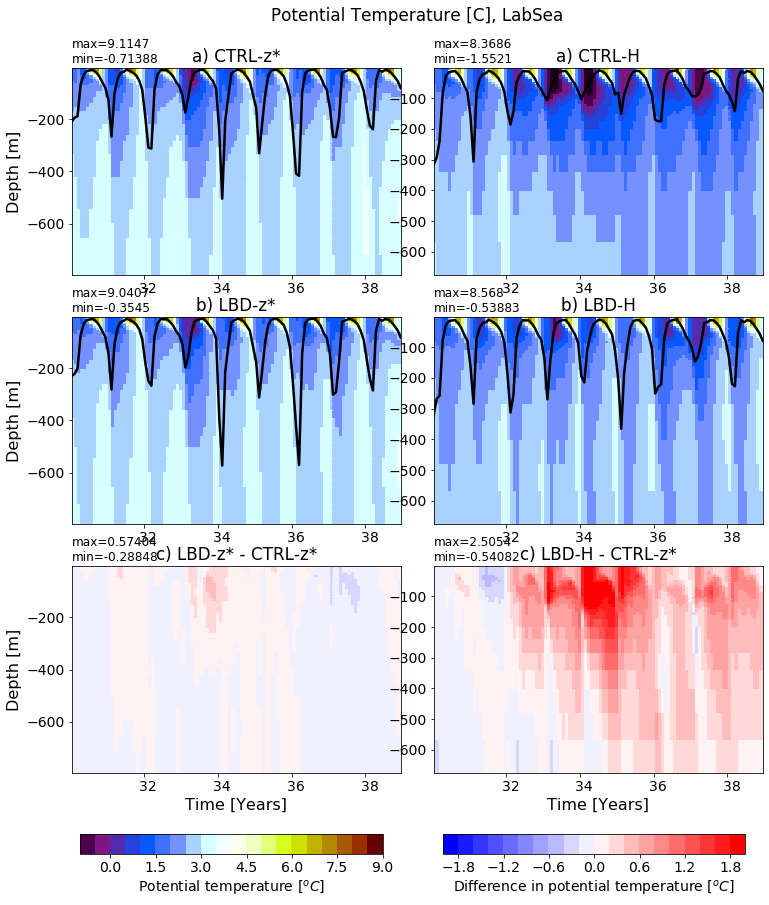

In [12]:
# temperature
var = 'thetao'
sd='0030-01-01'
ed='0038-12-31'
ct=False
clim=(-1, 9); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('Potential Temperature [C], LabSea', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_LabSea.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zl=slice(0,800))
  oml = ds.oml.values
  #print(ds[var].shape)
  dummy = np.ma.masked_invalid(ds[var].values)
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-2, 2), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)
   cb1 = ztplot(C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-2, 2), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'Potential temperature [$^oC$]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'Difference in potential temperature [$^oC$]', fontsize=14)
 

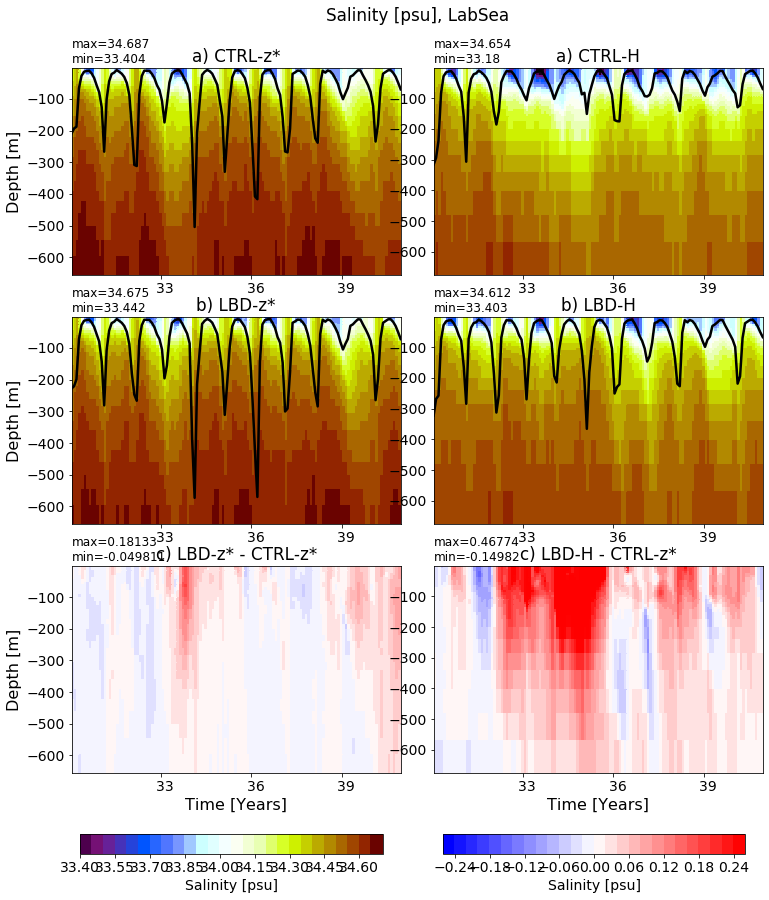

In [13]:
# salinity
var = 'so'
sd='0030-01-01'
ed='0040-12-31'
ct=False
clim=(33.4, 34.7); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('Salinity [psu], LabSea', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_LabSea.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zl=slice(0,700))
  oml = ds.oml.values
  #print(ds[var].shape)
  dummy = np.ma.masked_invalid(ds[var].values)
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.25, 0.25), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)
   cb1 = ztplot(C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.25, 0.25), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'Salinity [psu]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'Salinity [psu]', fontsize=14)
 

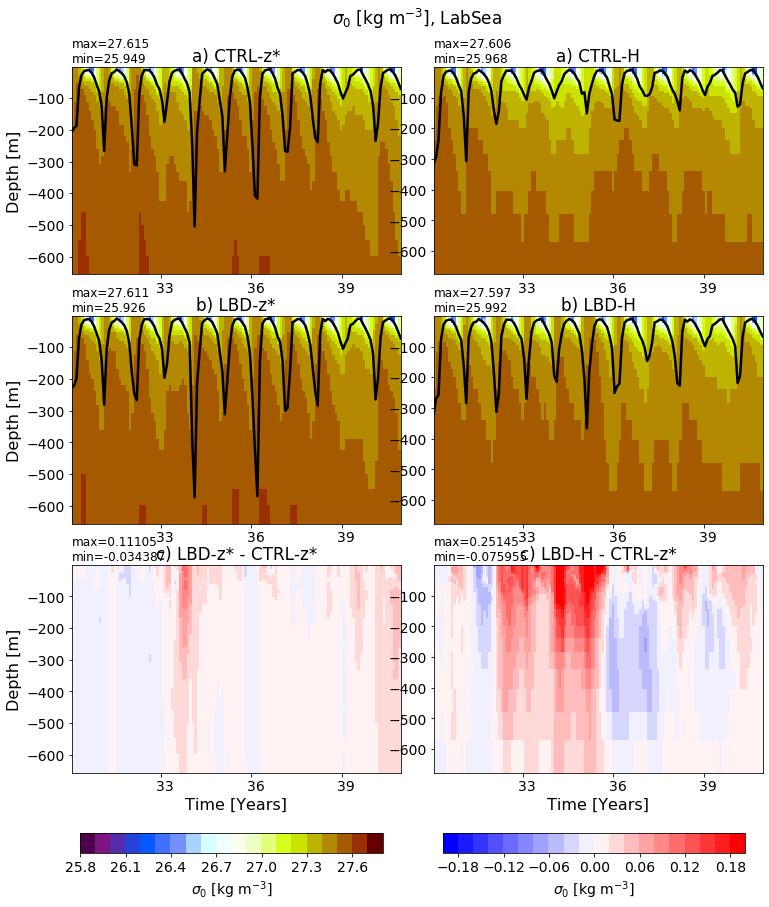

In [14]:
# rhopot0
var = 'rhopot0'
sd='0030-01-01'
ed='0040-12-31'

ct=False
clim=(25.8, 27.8); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('$\sigma_0$ [kg m$^{-3}$], LabSea', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_LabSea.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zl=slice(0,700))
  oml = ds.oml.values
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values) - 1000.
    cb1 = ztplot(C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)- 1000.
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.2, 0.2), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)- 1000.
   cb1 = ztplot(C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)- 1000.
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.2, 0.2), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'$\sigma_0$ [kg m$^{-3}$]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'$\sigma_0$ [kg m$^{-3}$]', fontsize=14)
 

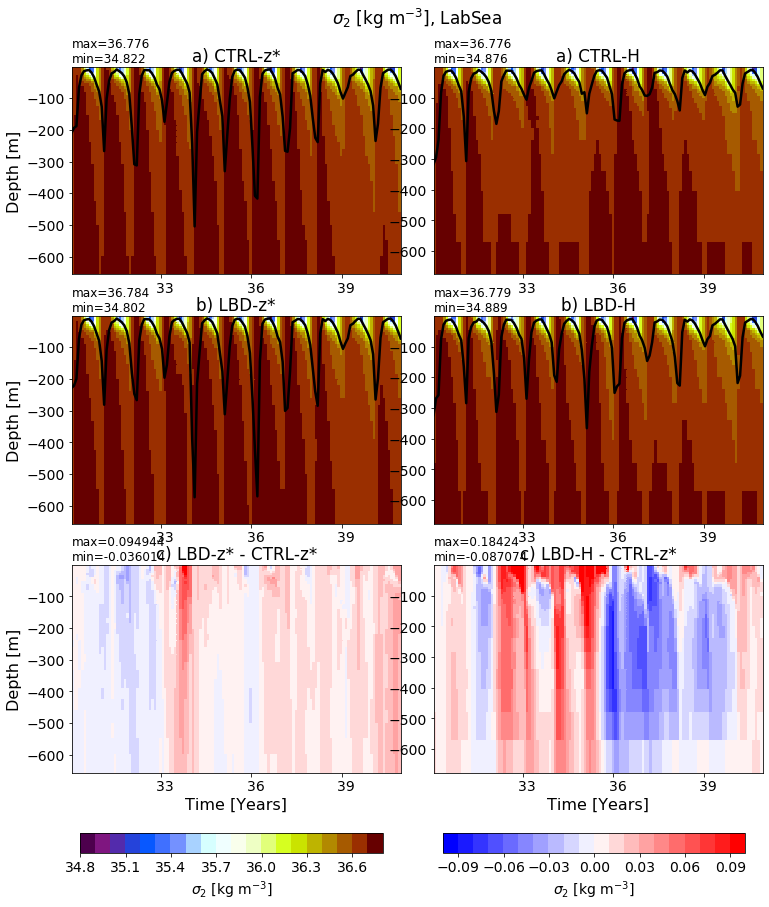

In [15]:
# rhopot2
var = 'rhopot2'
sd='0030-01-01'
ed='0040-12-31'

ct=False
clim=(34.8, 36.8); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('$\sigma_2$ [kg m$^{-3}$], LabSea', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_LabSea.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zl=slice(0,700))
  oml = ds.oml.values
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values) - 1000.
    cb1 = ztplot(C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)- 1000.
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.1, 0.1), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)- 1000.
   cb1 = ztplot(C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)- 1000.
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.1, 0.1), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'$\sigma_2$ [kg m$^{-3}$]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'$\sigma_2$ [kg m$^{-3}$]', fontsize=14)
 

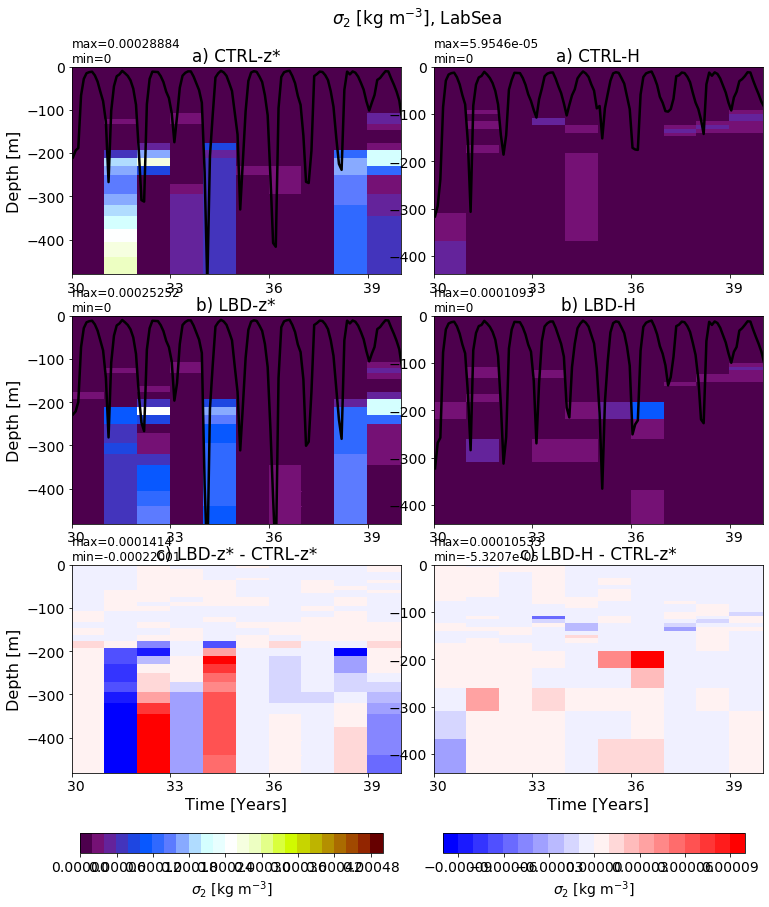

In [16]:
# N2
var = '__xarray_dataarray_variable__'
sd='0030-01-01'
ed='0040-12-31'

ct=False
clim=(1.0e-8, 5.0e-4); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('$\sigma_2$ [kg m$^{-3}$], LabSea', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_yearly_avg_over_LabSea.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zi=slice(0,500))
  ds1 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_LabSea.nc')
  ds1 = ds1.sel(time=slice(sd,ed))
  oml = ds1.oml.values
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values) 
    cb1 = ztplot(C1, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds1.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds1.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-1e-4, 1e-4), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)
   cb1 = ztplot(C2, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds1.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds1.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-1e-4, 1e-4), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'$\sigma_2$ [kg m$^{-3}$]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'$\sigma_2$ [kg m$^{-3}$]', fontsize=14)
 

### SouthernOcean 
Regional-averaged ocean properties

Max. depth in SouthernOcean is: 6000.0


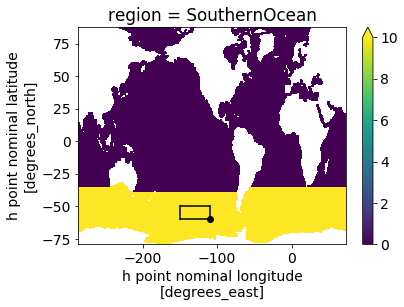

In [40]:
fig, ax = plt.subplots()
(basin_code.sel(region='SouthernOcean')*grd_xr.depth_ocean).plot(ax=ax,vmax=10)
#(basin_code.sel(region='SouthernOcean')*grd_xr.depth_ocean).sel(xh=slice(-150, -110)).sel(yh=slice(-60, -50)).plot(ax=ax)
ax.plot([-150,-110],[-60.,-60.],'k')
ax.plot([-150,-110],[-50.,-50.],'k')
ax.plot([-150,-150],[-60.,-50.],'k')
ax.plot([-110,-110],[-60.,-50.],'k')
ax.plot([-110.],[-60.],'ko')

#ax.set_xlim(-152,-105)
#ax.set_ylim(-60,-50)

print('Max. depth in SouthernOcean is:',(basin_code.sel(region='SouthernOcean')*grd_xr.depth_ocean).max().values)

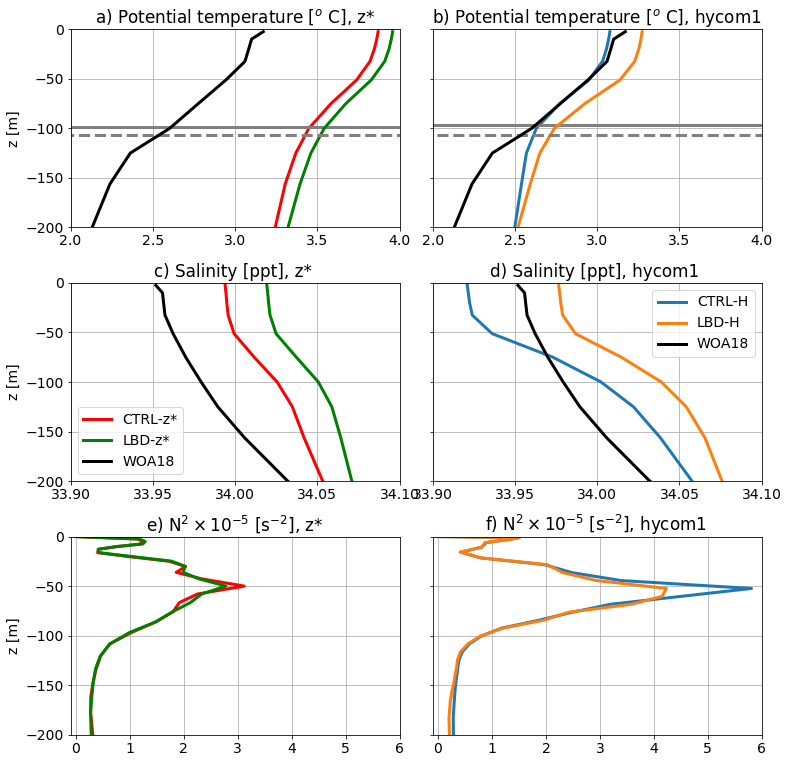

In [42]:
# profiles
#import seaborn as sns
#sns.set_theme(style="whitegrid")
matplotlib.rcParams.update({'font.size': 14})

# temperature
var = 'thetao'
sd='0001-01-01'
ed='0058-12-31'
reg='SouthernOcean'
max_depth = 300.
lw=3
thetao_obs_lab = thetao_obs.sel(xh=-110., method="nearest").sel(yh=-60., method="nearest").sel(z_l=slice(0,max_depth))
salt_obs_lab = salt_obs.sel(xh=-110., method="nearest").sel(yh=-60., method="nearest").sel(z_l=slice(0,max_depth))


matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14), sharey=True)
#plt.suptitle('Potential Temperature [C], LabSea', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_tracer_z_point_'+reg+'.nc')
  ds = ds.sel(time=slice(sd,ed)).mean('time').sel(z_l=slice(0,max_depth))
  ds1 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_oml_point_'+reg+'.nc')
  ds2 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_N2_point_'+reg+'.nc')
  ds2 = ds2.sel(time=slice(sd,ed)).mean('time').sel(zi=slice(0,max_depth))

  oml = ds1.oml.mean('time').values
  thetao = np.ma.masked_invalid(ds['thetao'].values)
  so = np.ma.masked_invalid(ds['so'].values)
  N2 = np.ma.masked_invalid(ds2['N2'].values)

  if i < 2:
    # z*
    if i == 0:
      ax1[0].plot(thetao,-ds.z_l.values, 'r', label=labels[i], lw=lw)
      ax1[2].plot(so,-ds.z_l.values, 'r', label=labels[i], lw=lw)
      ax1[4].plot(N2*1e5,-ds2.zi.values, 'r', label=labels[i], lw=lw)
      ax1[0].plot([0,6],-np.ones(2)*oml,'-',color='gray', lw=lw)
    else:
      ax1[0].plot(thetao,-ds.z_l.values, 'g',label=labels[i], lw=lw)
      ax1[2].plot(so,-ds.z_l.values, 'g', label=labels[i], lw=lw)
      ax1[4].plot(N2*1e5,-ds2.zi.values, 'g', label=labels[i], lw=lw)
      ax1[0].plot([0,6],-np.ones(2)*oml,'--',color='gray', lw=lw)
    

  else:
    ax1[1].plot(thetao,-ds.z_l.values, label=labels[i], lw=lw)
    if i == 2:
      ax1[1].plot([0,6],-np.ones(2)*oml,'-',color='gray', lw=lw)
    else:
      ax1[1].plot([0,6],-np.ones(2)*oml,'--', color='gray', lw=lw)
    
    ax1[3].plot(so,-ds.z_l.values, label=labels[i], lw=lw)
    ax1[5].plot(N2*1e5,-ds2.zi.values, label=labels[i], lw=lw)
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1, hspace=0.28)

# obs
ax1[0].plot(thetao_obs_lab.values, -thetao_obs_lab.z_l.values,'k',label='WOA18', lw=lw)
ax1[1].plot(thetao_obs_lab.values, -thetao_obs_lab.z_l.values,'k',label='WOA18', lw=lw)
ax1[2].plot(salt_obs_lab.values, -salt_obs_lab.z_l.values,'k',label='WOA18', lw=lw)
ax1[3].plot(salt_obs_lab.values, -salt_obs_lab.z_l.values,'k',label='WOA18', lw=lw)

# grid
ax1[0].grid();ax1[1].grid()
ax1[2].grid();ax1[3].grid()
ax1[4].grid();ax1[5].grid()

# titles
ax1[0].set_title(r'a) Potential temperature [$^o$ C], z* ')
ax1[1].set_title(r'b) Potential temperature [$^o$ C], hycom1 ')
ax1[2].set_title(r'c) Salinity [ppt], z* ')
ax1[3].set_title(r'd) Salinity [ppt], hycom1 ')
ax1[4].set_title(r'e) N$^2 \times 10^{-5}$ [s$^{-2}$], z* ')
ax1[5].set_title(r'f) N$^2 \times 10^{-5}$ [s$^{-2}$], hycom1 ')

# ylabels
ax1[0].set_ylabel(r'z [m]')
ax1[2].set_ylabel(r'z [m]')
ax1[4].set_ylabel(r'z [m]')

# labels
ax1[2].legend()
ax1[3].legend()

# lims
ax1[0].set_xlim(2,4)
ax1[1].set_xlim(2,4)
ax1[2].set_xlim(33.9,34.1)
ax1[3].set_xlim(33.9,34.1)
ax1[4].set_xlim(-0.1,6)
ax1[5].set_xlim(-0.1,6)

ax1[0].set_ylim(-200,0)
#ax1[0].invert_yaxis()
if saveplot:
    fname = 'PNG/profiles_southern_ocean.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

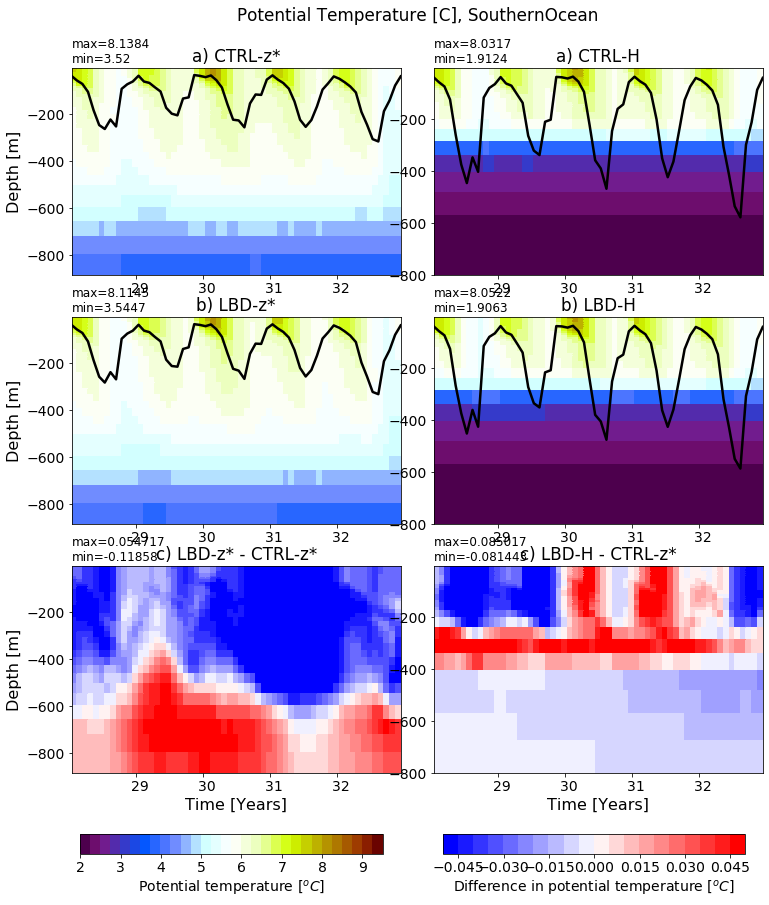

In [19]:
# temperature
var = 'thetao'
sd='0028-01-01'
ed='0032-12-31'
ct=False
clim=(2, 9.5); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('Potential Temperature [C], SouthernOcean', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_SouthernOcean.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zl=slice(0,900))
  oml = ds.oml.values
  #print(ds[var].shape)
  dummy = np.ma.masked_invalid(ds[var].values)
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.05, 0.05), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)
   cb1 = ztplot(C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.05, 0.05), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'Potential temperature [$^oC$]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'Difference in potential temperature [$^oC$]', fontsize=14)
 

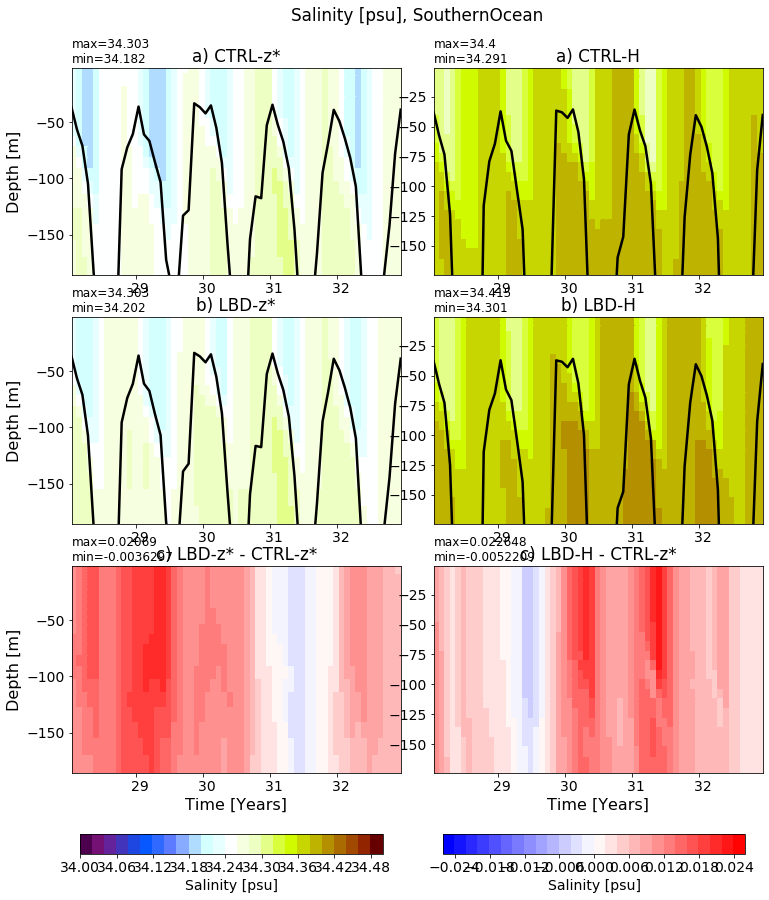

In [20]:
# salinity
var = 'so'
sd='0028-01-01'
ed='0032-12-31'
ct=False
clim=(34., 34.5); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('Salinity [psu], SouthernOcean', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_SouthernOcean.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zl=slice(0,200))
  oml = ds.oml.values
  #print(ds[var].shape)
  dummy = np.ma.masked_invalid(ds[var].values)
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.025, 0.025), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)
   cb1 = ztplot(C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-0.025, 0.025), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'Salinity [psu]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'Salinity [psu]', fontsize=14)
 

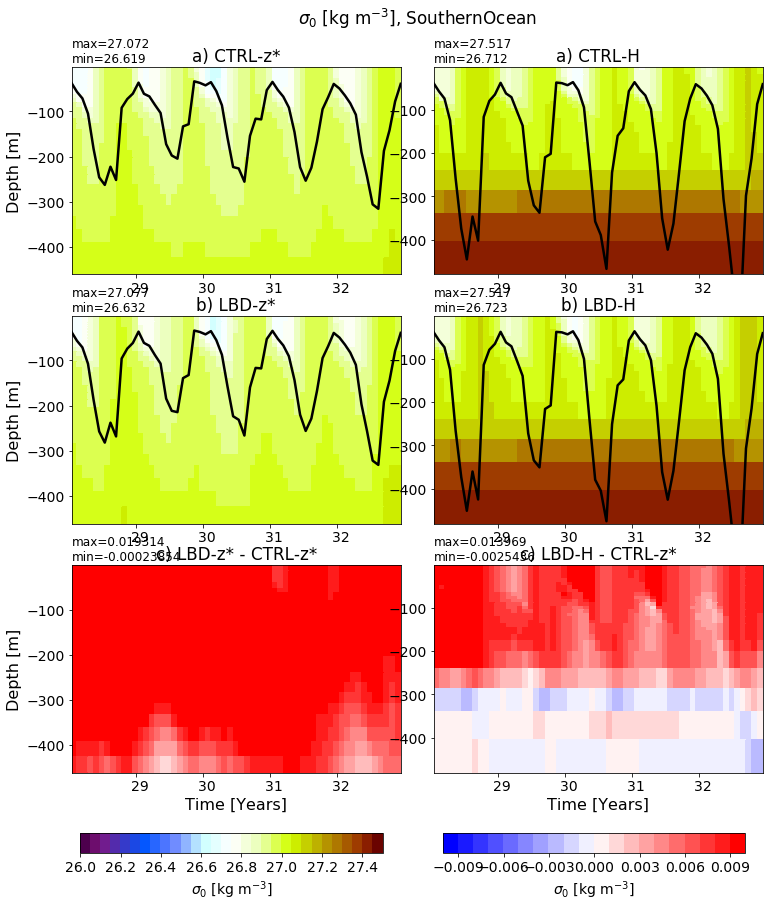

In [21]:
# rhopot0
var = 'rhopot0'
sd='0028-01-01'
ed='0032-12-31'

ct=False
clim=(26, 27.5); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('$\sigma_0$ [kg m$^{-3}$], SouthernOcean', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_SouthernOcean.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zl=slice(0,500))
  oml = ds.oml.values
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values) - 1000.
    cb1 = ztplot(C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)- 1000.
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-1e-2, 1e-2), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)- 1000.
   cb1 = ztplot(C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)- 1000.
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-1e-2, 1e-2), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'$\sigma_0$ [kg m$^{-3}$]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'$\sigma_0$ [kg m$^{-3}$]', fontsize=14)
 

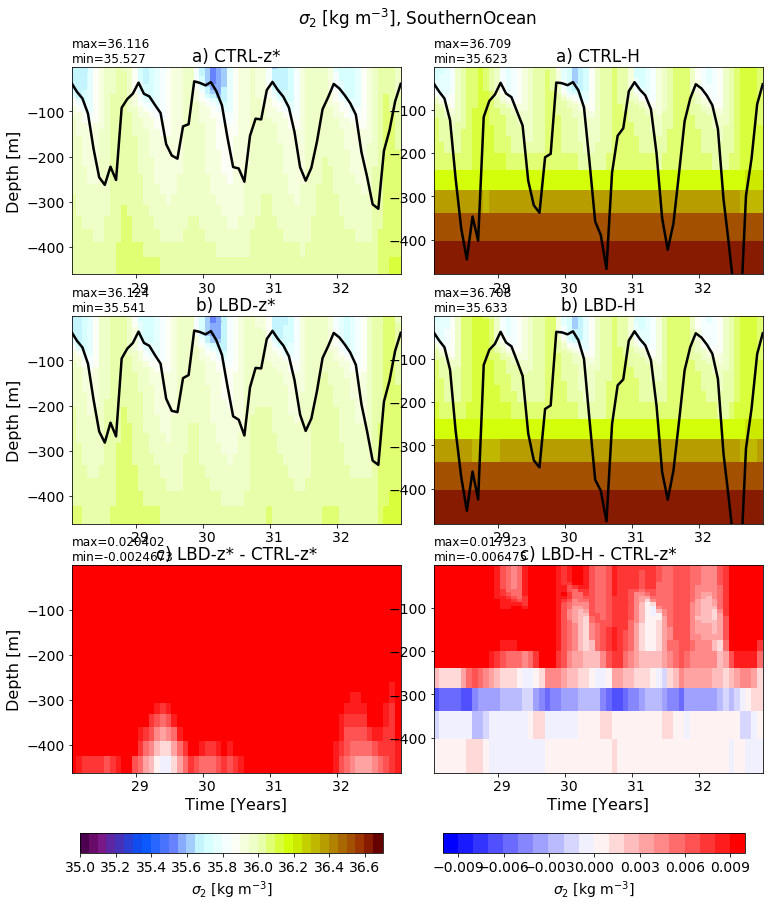

In [22]:
# rhopot0
var = 'rhopot2'
sd='0028-01-01'
ed='0032-12-31'

ct=False
clim=(35, 36.7); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('$\sigma_2$ [kg m$^{-3}$], SouthernOcean', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_SouthernOcean.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zl=slice(0,500))
  oml = ds.oml.values
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values) - 1000.
    cb1 = ztplot(C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)- 1000.
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-1e-2, 1e-2), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)- 1000.
   cb1 = ztplot(C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)- 1000.
    cb1 = ztplot(dummy, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zl.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-1e-2, 1e-2), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'$\sigma_2$ [kg m$^{-3}$]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'$\sigma_2$ [kg m$^{-3}$]', fontsize=14)
 

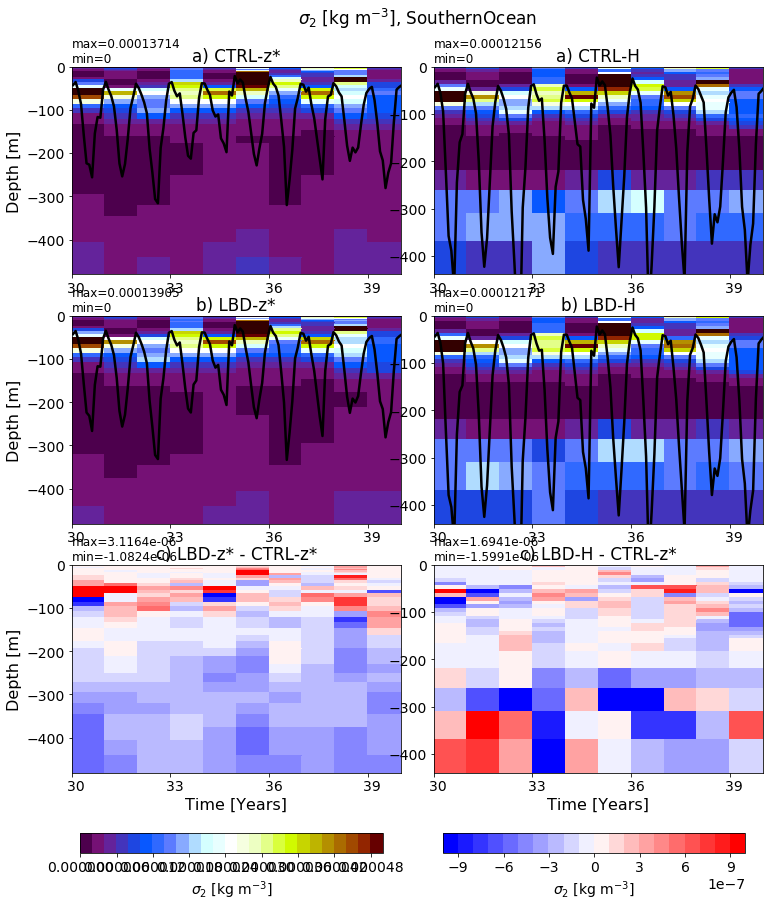

In [23]:
# N2
var = '__xarray_dataarray_variable__'
sd='0030-01-01'
ed='0040-12-31'

ct=False
clim=(0., 5.0e-5); clevs = np.linspace(clim[0],clim[1],5)
splitscale =  None#[0., -450., -500]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,14))
plt.suptitle('$\sigma_2$ [kg m$^{-3}$], SouthernOcean', y=0.96)
ax1 = ax.flatten()

for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_yearly_avg_over_SouthernOcean.nc')
  ds = ds.sel(time=slice(sd,ed)).sel(zi=slice(0,500))
  ds1 = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_monthly_avg_over_SouthernOcean.nc')
  ds1 = ds1.sel(time=slice(sd,ed))
  oml = ds1.oml.values
  if i == 0:
    C1 = np.ma.masked_invalid(ds[var].values) 
    cb1 = ztplot(C1, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].plot(ds1.time.values, -oml, 'k',lw=2.5)
    ax1[i].set_xlabel('')
  elif i == 1:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+1], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i+1].set_xlabel('');
    ax1[i+1].plot(ds1.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C1, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+3], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-1e-6, 1e-6), add_cbar=False);
    
  elif i == 2:
   C2 = np.ma.masked_invalid(ds[var].values)
   cb1 = ztplot(C2, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i-1], title='a) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
   ax1[i-1].set_xlabel(''); ax1[i-1].set_ylabel('')
   ax1[i-1].plot(ds1.time.values, -oml, 'k',lw=2.5)
    
  elif i == 3:
    dummy = np.ma.masked_invalid(ds[var].values)
    cb1 = ztplot(dummy, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i], title='b) '+labels[i], extend='both', colormap='dunnePM', zlabel='Depth',
        autocenter=True, tunits='Years', show=False, clim=clim, clevs=clevs, add_cbar=False);
    ax1[i].set_ylabel(''); ax1[i].set_xlabel('')
    ax1[i].plot(ds1.time.values, -oml, 'k',lw=2.5)
    
    cb2 = ztplot(dummy - C2, ds.time.values, ds.zi.values*-1, ignore=np.nan, splitscale=splitscale, contour=ct, 
        axis=ax1[i+2], title='c) '+str(labels[i])+ ' - ' + str(labels[0]), extend='both', colormap=plt.cm.bwr, 
        zlabel='Depth', autocenter=True, tunits='Years', show=False, clim=(-1e-6, 1e-6), add_cbar=False);
    ax1[i+2].set_ylabel('')
    
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1)

cbar_ax1 = fig.add_axes([0.11, 0.12, 0.35, 0.02])
cbar1=fig.colorbar(cb1, orientation='horizontal', cax=cbar_ax1)
cbar1.set_label(r'$\sigma_2$ [kg m$^{-3}$]', fontsize=14)

cbar_ax2 = fig.add_axes([0.53, 0.12, 0.35, 0.02])
cbar2=fig.colorbar(cb2, orientation='horizontal', cax=cbar_ax2)
cbar2.set_label(r'$\sigma_2$ [kg m$^{-3}$]', fontsize=14)
 